In [2]:
"""
Computing a connectome with sparse inverse covariance
=======================================================

This example constructs a functional connectome using the sparse inverse
covariance.

We use the `MSDL atlas
<https://team.inria.fr/parietal/research/spatial_patterns/spatial-patterns-in-resting-state/>`_
of functional regions in rest, and the
:class:`nilearn.input_data.NiftiMapsMasker` to extract time series.

Note that the inverse covariance (or precision) contains values that can
be linked to *negated* partial correlations, so we negated it for
display.

As the MSDL atlas comes with (x, y, z) MNI coordinates for the different
regions, we can visualize the matrix as a graph of interaction in a
brain. To avoid having too dense a graph, we represent only the 20% edges
with the highest values.

"""

'\nComputing a connectome with sparse inverse covariance\n=======================================================\n\nThis example constructs a functional connectome using the sparse inverse\ncovariance.\n\nWe use the `MSDL atlas\n<https://team.inria.fr/parietal/research/spatial_patterns/spatial-patterns-in-resting-state/>`_\nof functional regions in rest, and the\n:class:`nilearn.input_data.NiftiMapsMasker` to extract time series.\n\nNote that the inverse covariance (or precision) contains values that can\nbe linked to *negated* partial correlations, so we negated it for\ndisplay.\n\nAs the MSDL atlas comes with (x, y, z) MNI coordinates for the different\nregions, we can visualize the matrix as a graph of interaction in a\nbrain. To avoid having too dense a graph, we represent only the 20% edges\nwith the highest values.\n\n'

First subject functional nifti images (4D) are at: /home/takanori/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/takanori/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii

/home/takanori/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:94: DeprecationWarning: Function fetch_msdl_atlas is deprecated; it has been replace by fetch_atlas_msdl and will be removed in nilearn 0.1.5
  warnings.warn(msg, category=DeprecationWarning)
/home/takanori/anaconda/lib/python2.7/site-packages/nilearn-0.1.5.dev0-py2.7.egg/nilearn/_utils/cache_mixin.py:218: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "



Resampling maps
[Memory]    0.0s, 0.0min: Loading resample_img...
________________________________________resample_img cache loaded - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/takanori/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', 
{ 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'maps_img': '/home/takanori/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=['/home/takanori/nilearn_data/adhd/data/0010042/0010042_regressors.csv'], memory_level=1, verbose=5, memory=Memory(cachedir='nilearn_cache/joblib'))
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/takanori/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMa

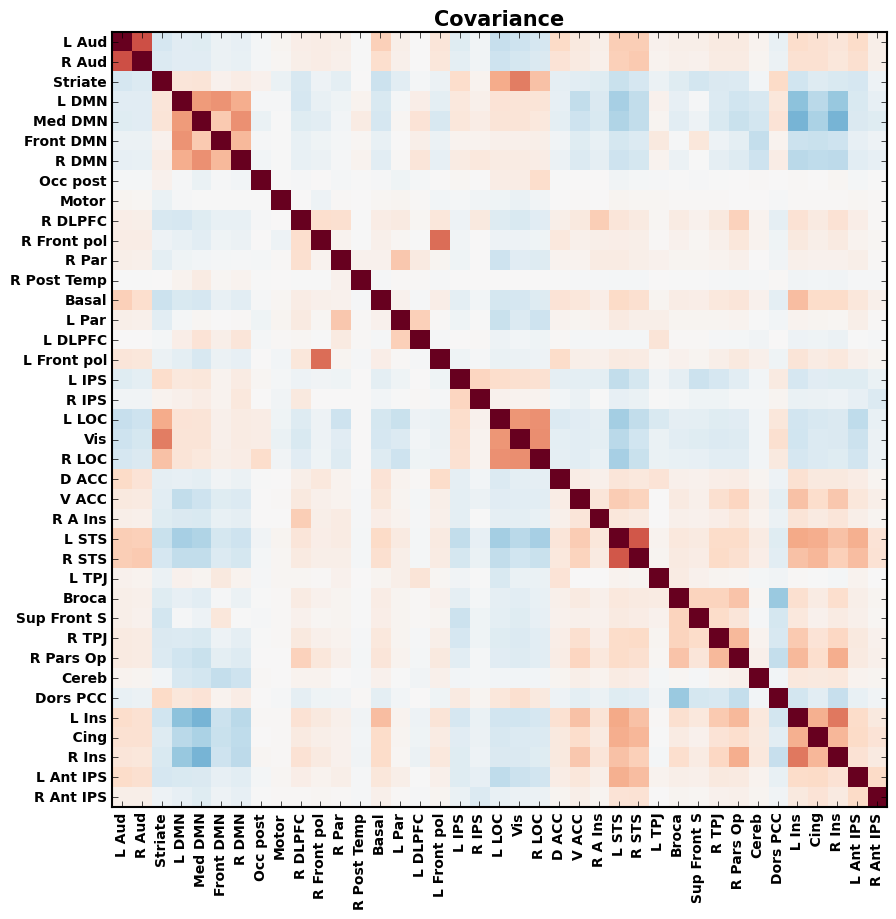

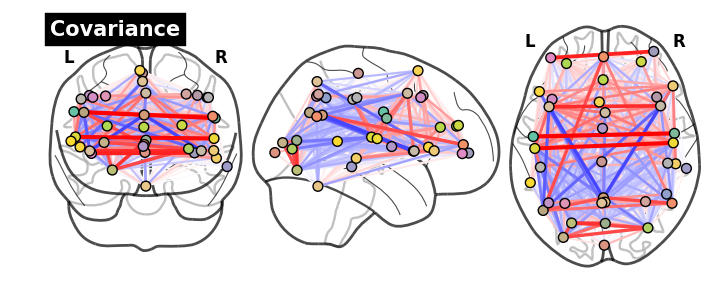

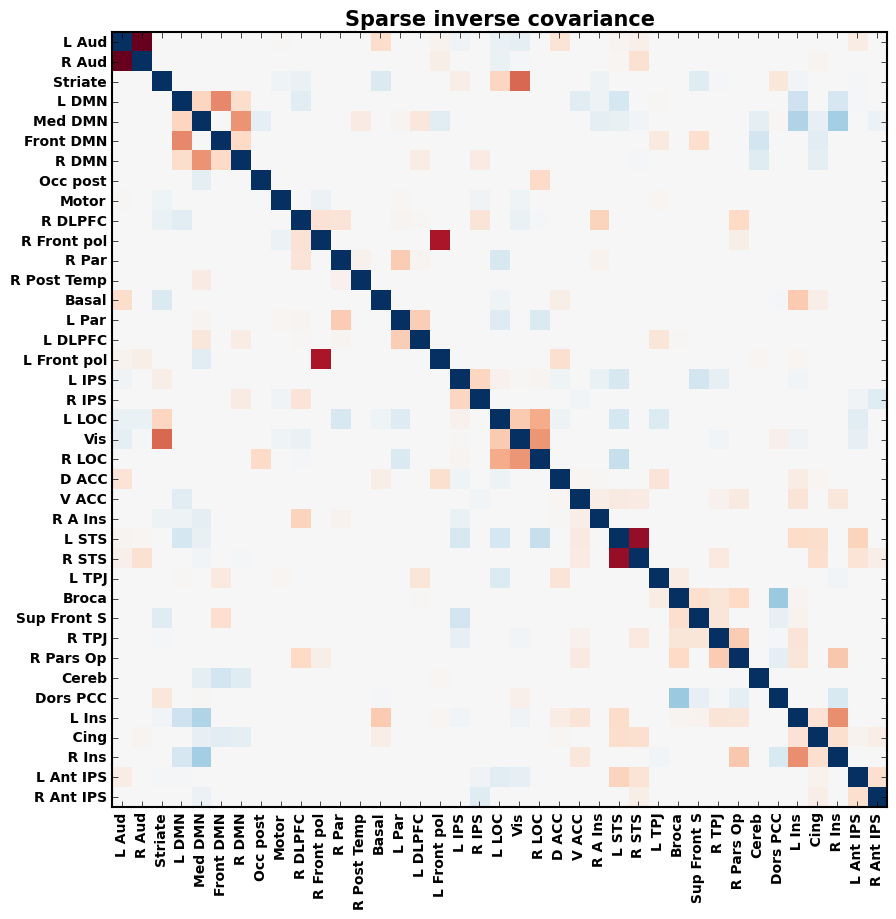

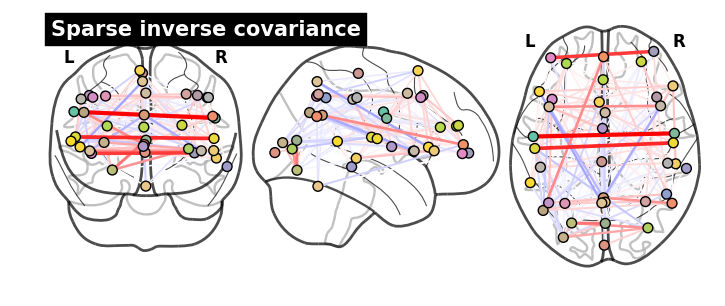

In [3]:
from nilearn import datasets
atlas = datasets.fetch_msdl_atlas()
atlas_filename = atlas['maps']

# Load the labels
import numpy as np
csv_filename = atlas['labels']

# The recfromcsv function can load a csv file
labels = np.recfromcsv(csv_filename)
names = labels['name']

from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

data = datasets.fetch_adhd(n_subjects=1)

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      data.func[0])  # 4D data

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

# Compute the sparse inverse covariance
from sklearn.covariance import GraphLassoCV
estimator = GraphLassoCV()

estimator.fit(time_series)

# Display the connectome matrix
from matplotlib import pyplot as plt

from nilearn import plotting
coords = np.vstack((labels['x'], labels['y'], labels['z'])).T

# Display the covariance
plt.figure(figsize=(10, 10))
plt.imshow(estimator.covariance_, interpolation="nearest",
           vmax=1, vmin=-1, cmap=plt.cm.RdBu_r)
# And display the labels
x_ticks = plt.xticks(range(len(names)), names, rotation=90)
y_ticks = plt.yticks(range(len(names)), names)
plt.title('Covariance')

# And now display the corresponding graph
plotting.plot_connectome(estimator.covariance_, coords,
                         title='Covariance')


# Display the sparse inverse covariance (we negate it to get partial
# correlations)
plt.figure(figsize=(10, 10))
plt.imshow(-estimator.precision_, interpolation="nearest",
           vmax=1, vmin=-1, cmap=plt.cm.RdBu_r)
# And display the labels
x_ticks = plt.xticks(range(len(names)), names, rotation=90)
y_ticks = plt.yticks(range(len(names)), names)
plt.title('Sparse inverse covariance')

# And now display the corresponding graph
plotting.plot_connectome(-estimator.precision_, coords,
                         title='Sparse inverse covariance')

plt.show()